In [1]:
%run init.ipy

from lib import constants
from lib import klatt
from lib import util
import random
from vtr.prior import formant
from lib import timit
from inv import process
from inv import model
from vtr.prior import filter

2023-02-17 23:09:55.861769: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-17 23:09:55.861816: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-17 23:09:55.861821: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
def rand_triple():
    vtr_root = timit.test_set(timit.VTRFORMANTS)
    timit_root = timit.test_set(timit.TIMIT)
    l = list(timit.yield_file_triples(vtr_root, timit_root))
    return random.choice(l)

fb_file, phn_file, wav_file = rand_triple()

In [3]:
import pathlib
fb_file, phn_file, wav_file = (
 pathlib.PosixPath('/home/marnix/thesis/py/../data/VTRFormants/TEST/DR3/MLNT0/SI1902.FB'),
 pathlib.PosixPath('/home/marnix/thesis/py/../data/TIMIT/TEST/DR3/MLNT0/SI1902.PHN'),
 pathlib.PosixPath('/home/marnix/thesis/py/../data/TIMIT/TEST/DR3/MLNT0/SI1902.WAV')
)

[Memory]25.3s, 0.4min   : Loading get_aplawd_training_pairs_subset...
[Memory]58.9s, 1.0min   : Loading run_nested...
[Memory]60.4s, 1.0min   : Loading run_nested...
[Memory]61.8s, 1.0min   : Loading run_nested...
[Memory]63.1s, 1.1min   : Loading run_nested...
NP = 4
Number of data points: 379
Number of model dimensions: 82


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 128,
  'use_oq': True,
  'impose_null_integral': True},
 PoleZeroFilter(4))

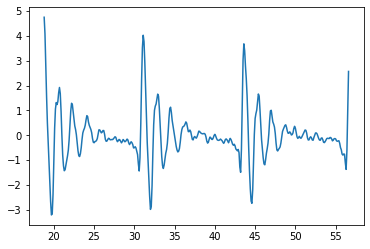

In [4]:
source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = True
)

vtfilter = filter.PZ(4, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

hyper = process.make_rand_hyper(
    (fb_file, phn_file, wav_file),
    source_config = source_config,
    vtfilter = vtfilter,
    process_data_kwargs=dict(max_NP = 4, prepend=1)
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

## Try ESS with N(0,I) prior

It might be much more efficient to use the full covariance matrix, because ESS might use that structure for better drows. But first we try the whitened one.

In [5]:
import blackjax
import jax.scipy

In [6]:
#hyper = process.hyper_variation(hyper, filter=filter.PZ(5, numpy_backend=jax.numpy, scipy_backend=jax.scipy))

In [7]:
ndim = model.ndim(hyper)
print(ndim)
theta_bijector = model.theta_trajectory_bijector(hyper)

def logabsdet_delw_deltheta(w):
    return -theta_bijector.forward_log_det_jacobian(w)

def loglike(w):
    """Return L(theta(w)) where a priori w ~ N(0, I)"""
    theta = theta_bijector.forward(w)
    logcorrection = logabsdet_delw_deltheta(w)
    loglikelihood = model.full_likelihood(theta, hyper)
    return loglikelihood + logcorrection

def logjoint(w):
    return loglike(w) + jnp.sum(jax.scipy.stats.norm.logpdf(w))

# Test our likelihood and joint functions: OK
prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())

l1 = model.full_likelihood(theta, hyper) + prior.log_prob(theta)

#
w = theta_bijector.inverse(theta)
l2 = logjoint(w)

#
l1, l2

82
[Memory]285.6s, 4.8min  : Loading get_aplawd_training_pairs_subset...
[Memory]285.9s, 4.8min  : Loading posterior_of_fitted_lf_values...
[Memory]286.0s, 4.8min  : Loading run_nested...
[Memory]286.2s, 4.8min  : Loading get_aplawd_training_pairs_subset...
[Memory]292.8s, 4.9min  : Loading posterior_of_fitted_TFB_values...
[Memory]293.1s, 4.9min  : Loading run_nested...
[Memory]293.2s, 4.9min  : Loading get_vtrformants_training_data...
[Memory]309.1s, 5.2min  : Loading run_nested...
[Memory]309.9s, 5.2min  : Loading run_nested...
[Memory]310.8s, 5.2min  : Loading run_nested...
[Memory]311.6s, 5.2min  : Loading run_nested...
[Memory]311.7s, 5.2min  : Loading get_vtrformants_training_data...
[Memory]319.5s, 5.3min  : Loading posterior_of_fitted_lf_values...
[Memory]319.5s, 5.3min  : Loading run_nested...
[Memory]319.6s, 5.3min  : Loading posterior_of_fitted_TFB_values...
[Memory]319.6s, 5.3min  : Loading run_nested...


(DeviceArray(-3230.03597517, dtype=float64),
 DeviceArray(-3230.03597517, dtype=float64))

In [8]:
import jax.random as jrnd

def inference_loop(rng, init_state, kernel, n_iter):
    keys = jrnd.split(rng, n_iter)

    @jax.jit
    def step(state, key):
        state, info = kernel(key, state)
        return state, (state, info)

    _, (states, info) = jax.lax.scan(step, init_state, keys)
    return states, info

CPU times: user 12min 22s, sys: 159 ms, total: 12min 22s
Wall time: 12min 20s


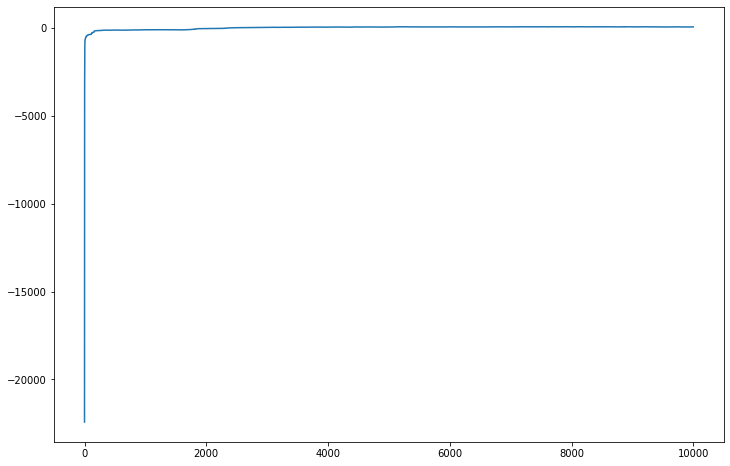

In [20]:
%%time
n_iter = 10000

init, kernel = blackjax.elliptical_slice(
    loglike, mean=jnp.zeros(ndim), cov=jnp.eye(ndim)
)

w0 = randn(ndim)

states, info = inference_loop(
    jaxkey(), init(w0), kernel, n_iter
)

samples = states.position
plot(states.loglikelihood)

0	log L = 132.63350620824838	SNR [dB] = 17.893552560932665
1	log L = 136.716236773483	SNR [dB] = 18.54751274382966
2	log L = 125.76298513714619	SNR [dB] = 18.182991376208214
3	log L = 134.05686961797642	SNR [dB] = 18.36559159796273
4	log L = 130.22198604418338	SNR [dB] = 18.32043844754335
5	log L = 124.51227890953112	SNR [dB] = 18.322450505267064
6	log L = 137.40439572069567	SNR [dB] = 19.004546095858405
7	log L = 133.0259709839504	SNR [dB] = 18.298465252390407
8	log L = 121.38893157214534	SNR [dB] = 18.323262506966994
9	log L = 119.8050601201993	SNR [dB] = 17.880773495827658


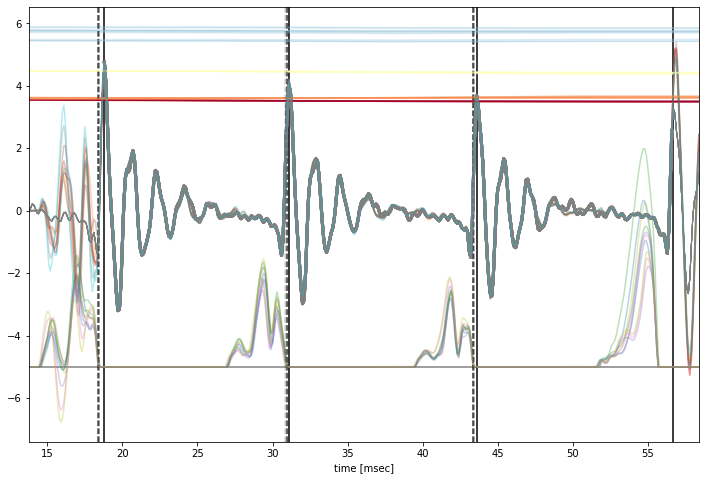

In [22]:
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

nsamp = 10
warmup = int(n_iter/2)
tail = n_iter - warmup
w_samples = samples[-tail:,:][np.random.randint(tail, size=nsamp),:]

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

In [18]:
theta

{'noise_sigma': DeviceArray(0.12707064, dtype=float64),
 'delta': DeviceArray(0.29415847, dtype=float64),
 'source': DeviceArray([[ 2.08391092,  0.06554004, 12.53755642,  0.32069343],
              [ 1.90909846,  0.06597798, 13.5617748 ,  0.31891331],
              [ 1.89451737,  0.07084505, 13.05970724,  0.32110813],
              [ 1.82875947,  0.0672605 , 13.93048293,  0.32084361]],            dtype=float64),
 'filter': DeviceArray([[ 565.27052306,  970.56190258, 1477.368406  , 2033.81534924,
                126.49457206,  611.52288336,  122.49997381,   30.20589135],
              [ 570.99044816,  916.0499617 , 1436.32384167, 2036.70891095,
                145.9129563 ,  558.62162368,   94.25370084,   32.94058749],
              [ 566.80049896,  846.49295638, 1399.03566452, 2044.09751257,
                176.10595263,  525.63146567,   64.40171593,   36.27213047],
              [ 574.22438249,  831.7286029 , 1371.42366135, 2044.8945991 ,
                194.72754754,  548.5028199 ,  

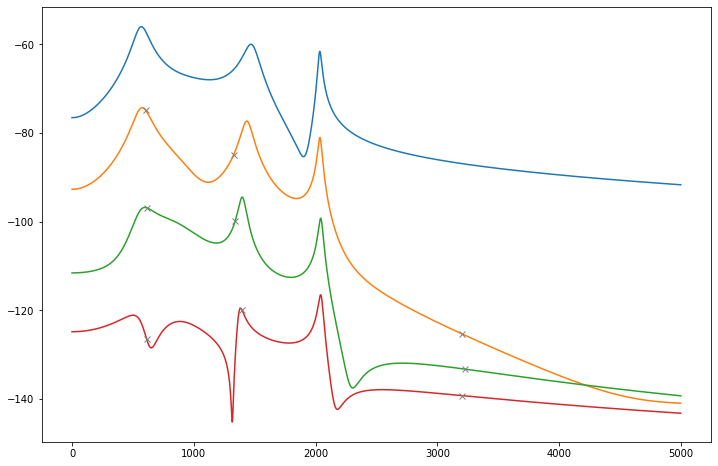

In [19]:
f = constants.spectrum_frequencies()

powers = jax.vmap(hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")

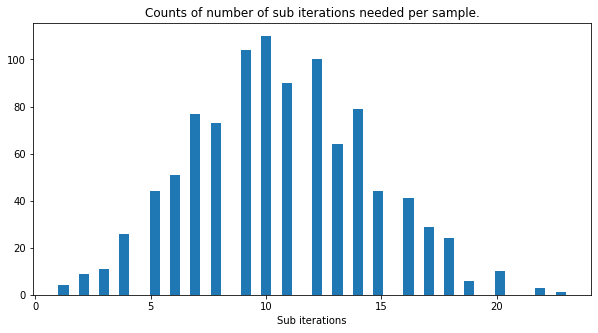

In [22]:
plt.figure(figsize=(10, 5))
plt.hist(np.array(info.subiter), bins=50)
plt.xlabel("Sub iterations")
plt.title("Counts of number of sub iterations needed per sample.")
plt.show()

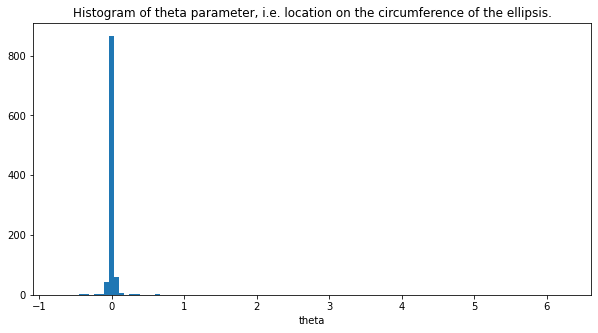

In [23]:
plt.figure(figsize=(10, 5))
plt.hist(np.array(info.theta), bins=100)
plt.xlabel("theta")
plt.title(
    "Histogram of theta parameter, i.e. location on the circumference of the ellipsis."
)
plt.show()